In [1]:
import os
import sys
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Sentinel-3
manacapuru_xls_path = 'D:\\processing\\win\\MANACAPURUv9b.xlsx'
df_s3 = pd.read_excel(manacapuru_xls_path, sheet_name=0)
# removes hour:minute:seconds from Sentinel-3 data.
df_s3['Date'] = [e.replace(hour=0, minute=0, second=0) for e in df_s3['Datetime']]
df_s3_srtd = df_s3.sort_values(by='Date')


In [3]:
# def drop_df_days_by_ref(df, df_col, op, df_ref, ref_col):
#     if op=='>':
#         df_out = df[df[df_col] > df_ref[ref_col].max()].index
#     df.drop(df_out, inplace=True)
#     return df

In [4]:
def ts_summary(df, title:str):
    print(title,
          len(df),
          'min',df['Datetime'].min(),
          'max',df['Datetime'].max())

In [5]:
def fill_missing_days(df):
    return df.set_index('Datetime').resample('1D').ffill().reset_index()

In [6]:
def get_dups_in_col(df,colnames:list):
    dprows = df.duplicated(keep=False,subset=colnames)
    return df[dprows]

In [7]:
def mod3r_keep_flag12(df):
    return df[(df['flag qualite'] == 1) | (df['flag qualite'] == 2)].copy()

In [8]:
def load_mod3r_xls(path, clearflags=False):
    
    # UNUSED. May be: MOD09Q1 / MYD09Q1 / VNP09H1
    sensor_str = os.path.basename(path).split('_')[1]
    
    # read excel file and import Date as string
    df = pd.read_excel(path, sheet_name=0, converters={'Date': str})
    
    df['Date'] = df['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
    
    df_srtd = df.sort_values(by='Date')
    
    df_srtd['Datetime'] = pd.to_datetime(df_srtd['Date'], errors='coerce')
    
    if clearflags:
        df_srtd = mod3r_keep_flag12(df_srtd)
    
    return df_srtd

In [9]:
xls_path = 'D:\\processing\\OTHER_PLATFORMS\\manacapuru_noinf'

xls_files = [os.path.join(xls_path, f) for f in os.listdir(xls_path)]

xls_files

['D:\\processing\\OTHER_PLATFORMS\\manacapuru_noinf\\14100000_MOD09Q1_commun_noinf.xls',
 'D:\\processing\\OTHER_PLATFORMS\\manacapuru_noinf\\14100000_MYD09Q1_commun_noinf.xls',
 'D:\\processing\\OTHER_PLATFORMS\\manacapuru_noinf\\14100000_VNP09H1_commun_noinf.xls']

In [10]:
# Load data form excel, sort by date and drop by flag
df_mod = load_mod3r_xls(xls_files[0],clearflags=True)
df_myd = load_mod3r_xls(xls_files[1],clearflags=True)
df_vir = load_mod3r_xls(xls_files[2],clearflags=True)

dfs = [df_mod,df_myd,df_vir]

In [11]:
for n,df in enumerate(dfs):
    # test for duplicates
    duplen = len(get_dups_in_col(df,['Date']))
    print('Duplicates:',duplen)   

Duplicates: 0
Duplicates: 0
Duplicates: 0


In [12]:
print(len(df_mod), len(df_myd), len(df_vir))

df_mod = fill_missing_days(df_mod)
df_myd = fill_missing_days(df_myd)
df_vir = fill_missing_days(df_vir)

print(len(df_mod), len(df_myd), len(df_vir))

(7298, 6431, 2947)

In [13]:
ts_summary(df_mod,'MOD')
ts_summary(df_myd,'MYD')
ts_summary(df_vir,'VIR')

MOD 7298 min 2000-02-26 00:00:00 max 2020-02-18 00:00:00
MYD 6431 min 2002-07-04 00:00:00 max 2020-02-10 00:00:00
VIR 2947 min 2012-02-02 00:00:00 max 2020-02-26 00:00:00


In [14]:
# Drop Sentinel-3 upper limit
s3_out = df_s3_srtd[df_s3_srtd['Date'] > df_myd['Datetime'].max()].index
s3_matc = df_s3_srtd.copy()
s3_matc.drop(s3_out, inplace=True)
len(s3_matc)

307

In [16]:
# drop days outside S3 range
df_mod = df_mod[df_mod['Datetime'].isin(s3_matc['Date'])]
df_myd = df_myd[df_myd['Datetime'].isin(s3_matc['Date'])]
df_vir = df_vir[df_vir['Datetime'].isin(s3_matc['Date'])]

len(df_mod), len(df_myd), len(df_vir)

(307, 307, 307)

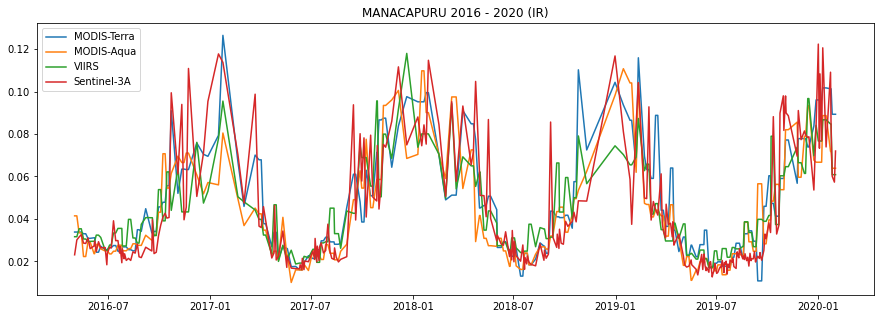

In [42]:
## CHECK DATES TO SEE HOW THEY FIT

plt.rcParams['figure.figsize'] = [15, 5]
plt.title('MANACAPURU 2016 - 2020 (IR)')
plt.plot(df_mod['Datetime'],df_mod['Bande IR estimee']/10000,label='MODIS-Terra')
plt.plot(df_myd['Datetime'],df_myd['Bande IR estimee']/10000,label='MODIS-Aqua')
plt.plot(df_vir['Datetime'],df_vir['Bande IR estimee']/10000,label='VIIRS')
plt.plot(s3_matc['Date'],s3_matc['B17-865'],label='Sentinel-3A')
plt.legend()
plt.savefig('manacapuru_compare_ir.png', bbox_inches='tight')

In [ ]:
## CREATING A SINGLE DF WITH ALL 4 SENSORS

s3_matc.reset_index(drop=True, inplace=True)
df_mod.reset_index(drop=True, inplace=True)
df_myd.reset_index(drop=True, inplace=True)
df_vir.reset_index(drop=True, inplace=True)

In [37]:
rouge_data = pd.concat([s3_matc['B8-665'],
                        df_mod['Bande rouge estimee']/10000,
                        df_myd['Bande rouge estimee']/10000,
                        df_vir['Bande rouge estimee']/10000],
                       axis=1,
                       keys=['S3', 'MOD', 'MYD', 'VIR'])

rouge_data.index = s3_matc['Date']

ir_data = pd.concat([s3_matc['B17-865'],
                     df_mod['Bande IR estimee']/10000,
                     df_myd['Bande IR estimee']/10000,
                     df_vir['Bande IR estimee']/10000],
                    axis=1,
                    keys=['S3', 'MOD', 'MYD', 'VIR'])

ir_data.index = s3_matc['Date']

In [43]:
rouge_data.to_csv('manacapuru_match_rouge.csv')
ir_data.to_csv('manacapuru_match_ir.csv')

## COMPUTING STATISTICS

## r²

In [56]:
df = rouge_data
# df = ir_data

In [45]:
from sklearn.metrics import r2_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

r2dict = {}

for sensor in list(df.columns):
    for col in df:
        result = r2_score(df[sensor],df[col]) # y_true / y_pred 
        r2dict[f'{sensor}:{col}'] = result

r2dict

{'S3:S3': 1.0,
 'S3:MOD': 0.6735070400462984,
 'S3:MYD': 0.6071864867461902,
 'S3:VIR': 0.6316709208477984,
 'MOD:S3': 0.623993309711976,
 'MOD:MOD': 1.0,
 'MOD:MYD': 0.6563598957816543,
 'MOD:VIR': 0.6914717520068012,
 'MYD:S3': 0.45681843041174963,
 'MYD:MOD': 0.5873890996844671,
 'MYD:MYD': 1.0,
 'MYD:VIR': 0.6927695020877962,
 'VIR:S3': 0.334464666202799,
 'VIR:MOD': 0.5159298621296475,
 'VIR:MYD': 0.5985413417016296,
 'VIR:VIR': 1.0}

## RMSE

In [46]:
from sklearn.metrics import mean_squared_error as mse

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmsedict = {}
rmsedict_yt = {}
rmsedict_yp = {}

for sensor in list(df.columns):
    for col in df:
        result = rmse(df[col],df[sensor])
        rmsedict[f'{sensor}:{col}'] = result
        rmsedict_yt[f'{sensor}:{col}'] = (result/df[sensor].mean())*100 # y_true
        rmsedict_yp[f'{sensor}:{col}'] = (result/df[col].mean())*100 # y_pred
        

print(rmsedict,'\n')

print(rmsedict_yt,'\n')
print(rmsedict_yp,'\n')

{'S3:S3': 0.0, 'S3:MOD': 0.015444222794354019, 'S3:MYD': 0.01694034915386074, 'S3:VIR': 0.01640390143290208, 'MOD:S3': 0.015444222794354019, 'MOD:MOD': 0.0, 'MOD:MYD': 0.014764549250613797, 'MOD:VIR': 0.01398993634116593, 'MYD:S3': 0.01694034915386074, 'MYD:MOD': 0.014764549250613797, 'MYD:MYD': 0.0, 'MYD:VIR': 0.012740369001703535, 'VIR:S3': 0.01640390143290208, 'VIR:MOD': 0.01398993634116593, 'VIR:MYD': 0.012740369001703535, 'VIR:VIR': 0.0} 

{'S3:S3': 0.0, 'S3:MOD': 37.95760540261464, 'S3:MYD': 41.63466800024611, 'S3:VIR': 40.316228660020805, 'MOD:S3': 35.34650199456139, 'MOD:MOD': 0.0, 'MOD:MYD': 33.790963552170695, 'MOD:VIR': 32.01814162947599, 'MYD:S3': 42.62637125677803, 'MYD:MOD': 37.15148678929178, 'MYD:MYD': 0.0, 'MYD:VIR': 32.05811722547603, 'VIR:S3': 38.870026201961196, 'VIR:MOD': 33.149991443754054, 'VIR:MYD': 30.18906684757246, 'VIR:VIR': 0.0} 

{'S3:S3': 0.0, 'S3:MOD': 35.34650199456139, 'S3:MYD': 42.62637125677803, 'S3:VIR': 38.870026201961196, 'MOD:S3': 37.957605402614

## MAPE

In [51]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mapedict = {}

for sensor in list(df.columns):
    for col in df:
        result = mape(df[sensor],df[col])
        mapedict[f'{sensor}:{col}'] = result
        
mapedict

{'S3:S3': 0.0,
 'S3:MOD': 28.908953321615172,
 'S3:MYD': 25.739881780193674,
 'S3:VIR': 31.102379590242336,
 'MOD:S3': 24.90334005276266,
 'MOD:MOD': 0.0,
 'MOD:MYD': 25.62021413506393,
 'MOD:VIR': 25.86214287827822,
 'MYD:S3': 25.796139178863488,
 'MYD:MOD': 25.104213735275398,
 'MYD:MYD': 0.0,
 'MYD:VIR': 25.946848138588745,
 'VIR:S3': 25.856069042632733,
 'VIR:MOD': 22.850435425760693,
 'VIR:MYD': 20.86897966449617,
 'VIR:VIR': 0.0}

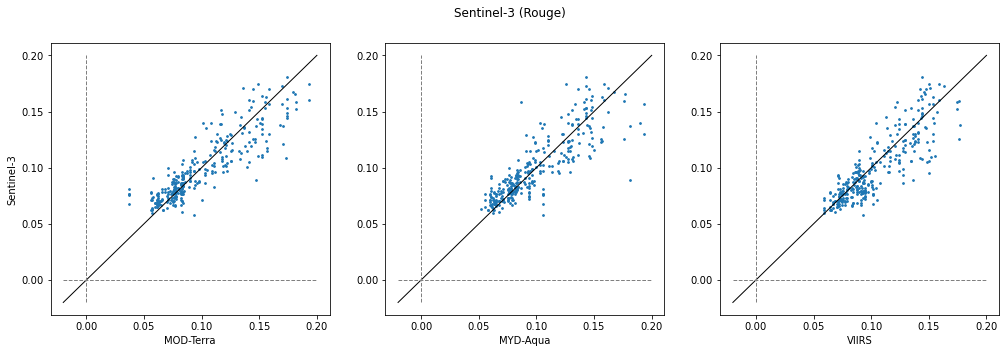

In [57]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('Sentinel-3 (Rouge)')

ax1.scatter(df.MOD, df.S3, s=3)
ax2.scatter(df.MYD, df.S3, s=3)
ax3.scatter(df.VIR, df.S3, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('Sentinel-3')

ax1.set_xlabel('MOD-Terra')
ax2.set_xlabel('MYD-Aqua')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_s3_rouge.png', bbox_inches='tight')

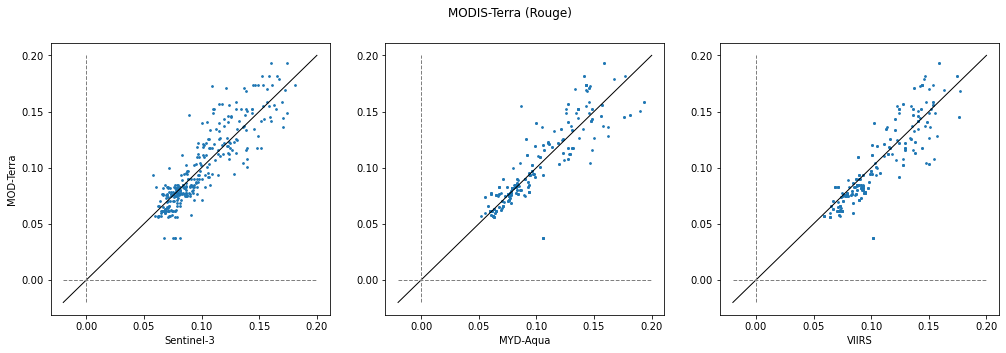

In [58]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('MODIS-Terra (Rouge)')

ax1.scatter(df.S3, df.MOD, s=3)
ax2.scatter(df.MYD, df.MOD, s=3)
ax3.scatter(df.VIR, df.MOD, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('MOD-Terra')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MYD-Aqua')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_mod_rouge.png', bbox_inches='tight')

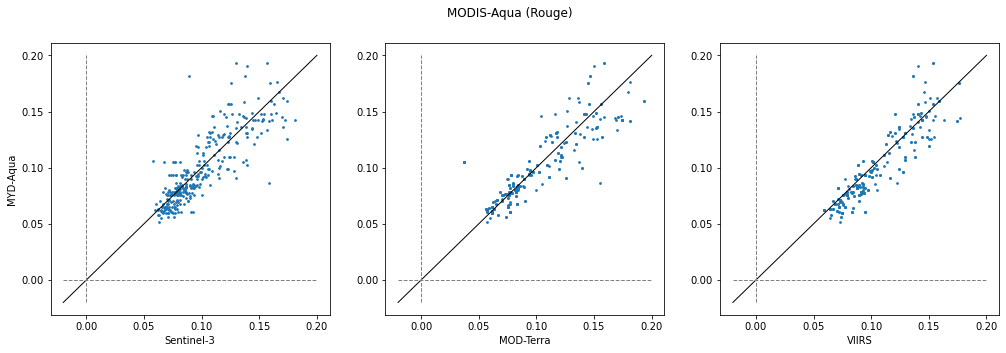

In [59]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('MODIS-Aqua (Rouge)')

ax1.scatter(df.S3, df.MYD, s=3)
ax2.scatter(df.MOD, df.MYD, s=3)
ax3.scatter(df.VIR, df.MYD, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('MYD-Aqua')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MOD-Terra')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_myd_rouge.png', bbox_inches='tight')

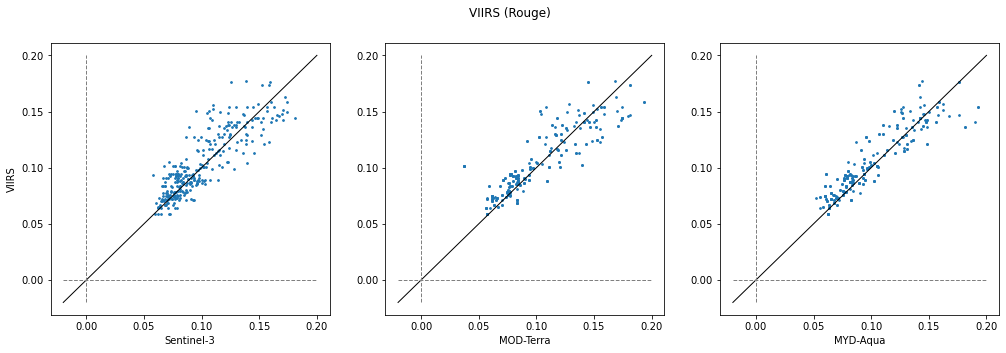

In [60]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('VIIRS (Rouge)')

ax1.scatter(df.S3, df.VIR, s=3)
ax2.scatter(df.MOD, df.VIR, s=3)
ax3.scatter(df.MYD, df.VIR, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('VIIRS')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MOD-Terra')
ax3.set_xlabel('MYD-Aqua')

plt.savefig('compare_vir_rouge.png', bbox_inches='tight')